In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

%matplotlib inline


# Kernel functions

The classifiers that we have studied are Linear: they create boundaries that are linear in the features in an attempt to separate classes.

That is: they work well when the classes are (nearly) Linearly Separable.



What if our classes don't appear to be Linearly Separable ?

We can try transforming the features so that, in the transformed features, the classes are separable.

# Transformations to induce Linear Separability

Transformations to induce linearity are interesting because
- They make our data linear in the new dimensions (features)
- when mapped back to our original dimensions, they introduce non-linearity, which can be powerful

As we will see, non-linear decision boundaries are a key part of Deep Learning.

In Classical Machine Learning, these transformations serve a similar role.

Let's explore a classification problem.  
- The colors denote different classes.
- We won't name the $\x_1, \x_2$ features

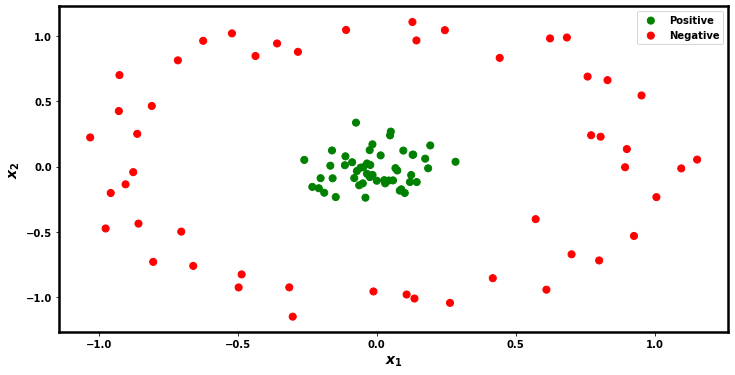

In [4]:
Xc, yc = svmh.make_circles(plot=True)

Doesn't appear to be linearly separable.

But, as we saw in the Transformation lecture, an RBF transformation does the trick:

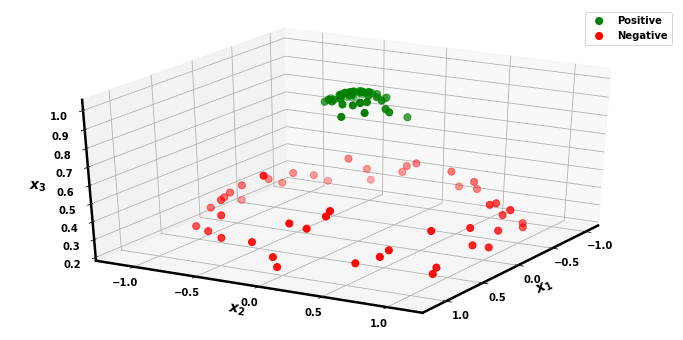

In [5]:
X_w_rbf = svmh.circles_rbf_transform(Xc)
_= svmh.plot_3D(X=X_w_rbf, y=yc )

Magic ! The new feature separates the two classes.
- Just like the polynomial feature make the curvy data set linear

The particular transformation is called Radial Basis Function (RBF) Transformation.

Here's the code that created the new feature "r".

Simple.  

Basically, the transformation creates a scalar measure (*similarity function*)
- The distance between
the existing features $\x^\ip$ of example $i$ and the features of a reference point.

In this case the reference point ("landmark") is the origin $(0,0)$ so
we don't write it explicitly.

In general the distance would be coded as
 `Xc - x_ref`
 
Examples that are very
close to the reference point have high values, and the values fall off sharply as the distance increases.


# Support Vector Machines: SVC's with integrated transformations

## Motivation

Nothing we have said about Linearity Inducing transformations should be new to you.

It is just like any other problem:
- Apply transformations
- Apply a model (Classifier)

**The issue with transformations**

Transformations may increase the number of features
- increased computational cost for the optimizer

A *Support Vector Machine* is an SVC that has been integrated with a *special class of transformations*.

These transformations are intimately tied to the mathematics of the SVC.

As a result, these transformations
- are specified as arguments to the model
- rather than separate statements implementing the transformation

So, rather than
- applying transformation $\phi$ to each example $\x$
$$
\tilde \x = \phi(\x)
$$
and then fitting the SVC to transformed examples $\tilde \X$

$$
\text{SVC.fit}(\tilde\X, \y)
$$
you specify the *name* of the transformation as argument to the model
- *without* computing $\tilde \X$

$$
\text{SVC.fit}(\X, \y, \text{kernel='name of kernel'})
$$


What makes these "integrated transformations" special ?

Consider a transformation $\phi$ 
- applied to a feature vector $\x^\ip$ of length $n$
$$\phi(\x^\ip)$$
- resulting in transformed vector $\tilde \x$ of length $n'$

Some transformations
- result in much bigger $n' \gg n$
    - increase space
- are computationally intensive

The integrated transformations
- incur no greater computational cost
- even when $n' \gg n$

The integrated transformations have the property
- we *achieve the effect* of fitting the model on transformed $\tilde \X = \phi(\X)$
- **without** having to incur the cost of computing $\phi(\X)$

A free lunch !
- no increase in space of time complexity

## Mathematics of the optimization problem

How do we achieve this "free lunch" ?

Let's examine the behavior of the quadratic optimizer used to solve SVC.

The SVC optimization problem minimizes
$$
\loss = \frac{1}{2} \Thetam^T \cdot \Thetam +  C * \frac{1}{m} \sum_{i=1}^m { \max{} \left( 0,  1 - \transy^\ip * s(\hat{\x}^\ip) \right) } 
$$
where
$$
\hat{s}(\x^\ip) = \Theta^T \cdot \x^\ip
$$

Because of the term $\frac{1}{2} \Thetam^T \cdot \Thetam $
- the Loss minimization problem is one of *quadratic optimization* with linear constraints

These are solvable via a technique (beyond the scope of the course) of Quadratic Programming.


A Quadratic Programming problems can be reformulated into a twin problem called 
its *dual form*.  The dual form for the SVC optimization problem is

**Dual form of the linear SVM objective (similar to Geron Equation 5-6)**

$
\begin{split}
\underset{\mathbf{\alpha}}{\operatorname{minimize}}
\dfrac{1}{2}\sum\limits_{i=1}^{m}{
  \sum\limits_{i'=1}^{m}{
  \alpha^{(i)} \alpha^{(i')} \transy^{(i)} \transy^{(i')} {\x^\ip}^T \x^{(i')}
  }
} \quad - \quad \sum\limits_{i=1}^{m}{\alpha^{(i)}}\\
\text{subject to}\quad \alpha^{(i)} \ge 0 \quad \text{for }i = 1, 2, \dots, m
\end{split}
$

It is beyond the scope of this course to explain the equation.

The key observations to take away from the above equation is
- The only sub-expression involving an example is when examples occur in pairs : $\x^\ip, \x^{(i')}$
- The only computation on the pair is the dot product $\x^\ip \cdot  \x^{(i')} = {\x^\ip}^T \x^{(i')}$

**Key point**

If we transform each $\x$ into $\tilde \x = \phi(\x)$
- the above equation requires us to compute

$$
\phi(\x^\ip) \cdot  \phi(\x^{(i')})
$$

## Kernels and the Kernel Trick

The integrated transformations are
- a way to compute 
$$
\phi(\x^\ip) \cdot  \phi(\x^{(i')})
$$

using only the dot product of the *untransformed* examples
$$
\x^\ip \cdot \x^{(i')}
$$

As the computation of the transformations 
- are expensive
- space intensive
- longer $\tilde \x$ results in more expensive dot product

it is very desirable to use these integrated transformations.

These integrated transformations are based on special functions called *kernels*.

A *kernel* is a function 
$$
K(\x^\ip, \x^{(i')})
$$
that is able to compute
$$
\phi(\x^\ip) \cdot  \phi(\x^{(i')})
$$
while only computing

$$
\x^\ip \cdot \x^{(i')}
$$

That is
- **it is not necessary** to implement the transformation !

So, in the optimization
- we replace the expensive term
$$
\phi(\x^\ip) \cdot  \phi(\x^{(i')})
$$
- with inexpensive term
$$
K(\x^\ip, \x^{(i')})
$$

The "integrated transformations"
- are restricted
- so that they have kernels that can compute them



### Example of a transformation with a Kernel function

In the optimization objective, we have terms of the form
$$
\phi(\x) \cdot \phi(\underline\x)
$$
for two examples $\x, \underline\x$ 

**Notation alert**
- we use $\x$ and $\underline\x$
- rather than our usual $\x^\ip$ and $\x^{(i')}$
- to denote two examples

because we will need superscripts to denote exponentiation
and desire a transformation to square each feature

Suppose we want a transformation
- to square each feature in vector $\x$ 

For $n = 2$:
$$
\phi(\x) = \begin{pmatrix}
\x_1^2 \\
\x_2^2
\end{pmatrix}
$$

This gives rise to terms of the form

$$
\phi(\x) \cdot  \phi(\underline \x) = 
\begin{pmatrix} 
    \x_1^2 \\
    \x_2^2
    \end{pmatrix}
    \cdot
    \begin{pmatrix} 
    \underline\x_1^2 \\
    \underline\x_2^2
    \end{pmatrix}
$$

This expression
- requires exponentiating $n$ terms (for each of the $n$ features of  $\x, \underline\x$)

It would be desirable to have a Kernel function 
- to compute $\phi(\x) \cdot  \phi(\underline \x)$
- *without* requiring $n$ exponentiations.

There may not (is not ?) such a Kernel function for the transformation
$$
\phi(\x) = \begin{pmatrix}
\x_1^2 \\
\x_2^2
\end{pmatrix}
$$

**But** there is a *similar* (not identical) transformation
$$
\phi\left(\mathbf{x}\right) = \phi\left( \begin{pmatrix}
  \x_1 \\
  \x_2
\end{pmatrix} \right) = \begin{pmatrix}
  {\x_1}^2 \\
  \sqrt{2} \, \x_1 \x_2 \\
  {\x_2}^2
\end{pmatrix}
$$
- that **does** have a Kernel function
- that avoids  invoking (expensive) transformation $\phi$

We can prove that 
this transformation 
- has Kernel function
$$K(\x, \underline \x) = \left(
\begin{pmatrix} 
    \x_1 \\
    \x_2
    \end{pmatrix}
    \cdot
    \begin{pmatrix} 
    \underline\x_1 \\
    \underline\x_2
    \end{pmatrix}   
\right)^2
$$

Note that 
- there is a single exponentiation
- of a *scalar* (the result of the dot product)
- rather than $n$ exponentiations

Much cheaper !

To see that this Kernel function computes
$$
\phi(\x) \cdot \phi(\underline\x)
$$
let's write out the steps.

$$
\begin{array}[llll]\\
\phi(\mathbf{\x}) \cdot \phi(\underline \x)  & = & 
\begin{pmatrix}
  {\x_1}^2 \\
  \sqrt{2} \, \x_1 \x_2 \\
  {\x_2}^2
  \end{pmatrix} \cdot \begin{pmatrix}
  {\underline \x_1}^2 \\
  \sqrt{2} \, \underline \x_1 \underline \x_2 \\
  {\underline \x_2}^2
\end{pmatrix} \\
& = & {\x_1}^2 {\underline \x_1}^2 + 2 \x_1 \underline \x_1 \x_2 \underline \x_2 + {\x_2}^2 {\underline \x_2}^2 \\
&  = & \left( \x_1 \underline \x_1 + \x_2 \underline \x_2 \right)^2 \\
&  = & \left( \begin{pmatrix}
  \x_1 \\
  \x_2
\end{pmatrix} \cdot \begin{pmatrix}
    \underline \x_1 \\
    \underline \x_2
  \end{pmatrix} \right)^2 \\
& = & ({\x} \cdot \underline   \x)^2 \\
& = & K(\x, \underline \x) \\
\end{array}  
$$

By using a transformation slightly different than our original goal
- we facilitate computing terms in the optimization
- that are much cheaper
- because they use a Kernel function
    - single exponentiation of a *scalar* (result of $\x \cdot \underline\x$
    - rather than $n$ exponentiations


Here are some examples of kernel transformation, paired with their "natural" counterparts.

Why the differences ?
- The kernel transformation is not identical to the natural (e.g., Polynomial)
- Possible differences in parameters

In [6]:
svmh = svm_helper.SVM_Helper()

_= svmh.create_kernel_data()
fig, axs = svmh.plot_kernel_vs_transform()
plt.close()

/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


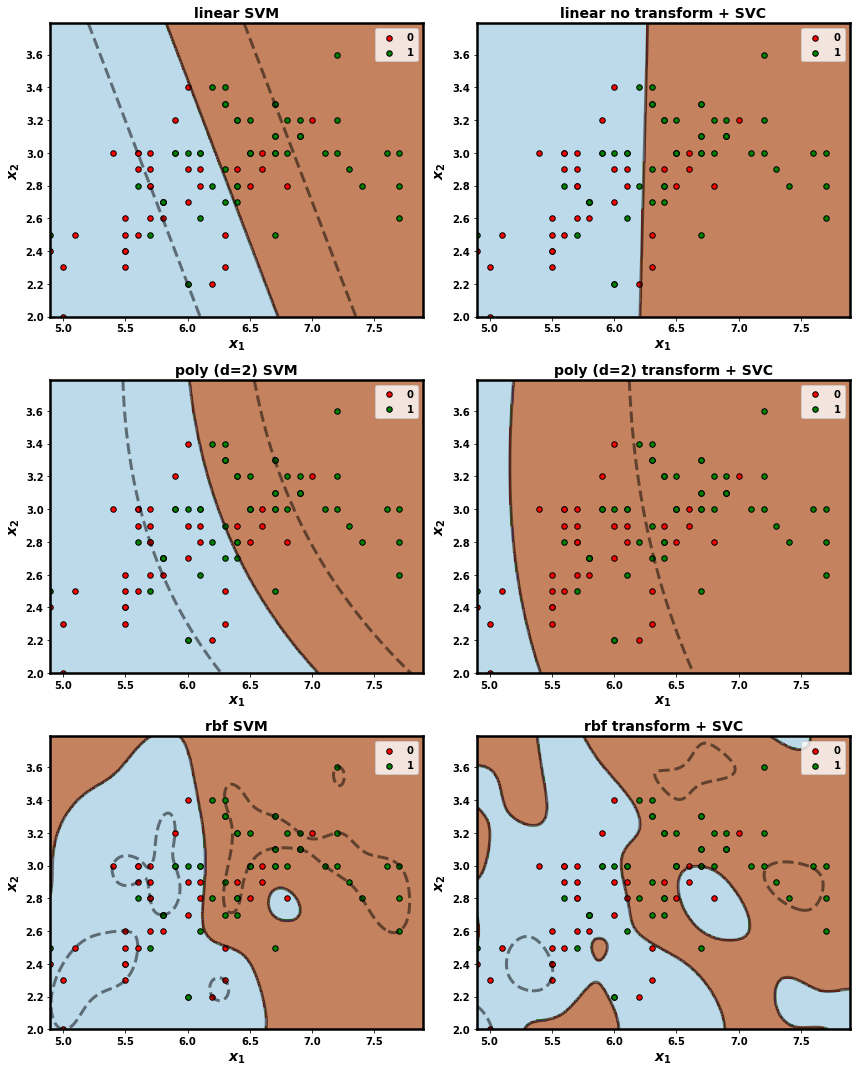

In [7]:
fig

## Some Kernel functions
[kernels](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/#linear)

There are a number of common kernel functions.
We investigate just a handful:

### Linear

The linear kernel

$$
K(\x, \x^{(i')}) = \x^T \cdot \x^{(i')} + c
$$

corresponds to a $\phi$ that is the identity transformation $\phi(\x) = \x$.

The linear kernel results in something very close to plain logistic regression.

### Gaussian

The Gaussian Radial Basis Function (RBF)

$$
K(\x, \x^{(i')}) =  \exp( - \frac{1}{2 \sigma^2} * \mid\mid  \x - \x^{(i')} \mid\mid^2 )
$$


The form of this function is that of a Gaussian distribution with mean $0$ and standard deviation $\sigma$.

The similarity is maximized when $\x$ and  $\x^{(i')}$ are close
in Euclidean space (due to the 2-norm $\mid\mid \; \mid\mid^2$)

When $\sigma$ is small, there is a sharp drop-off from the maximum at $\x^{(i')}$ to near-by points.

Conversely, when $\sigma$ is large, the drop-off is much smoother.


Note the presence of the *hyper parameter* $\sigma$.

How do we choose the right value ?

We don't need to !
- Consider $\sigma$ to be just like $\Theta$: a parameter that the optimizer solves for
    - Let the optimizer simultaneously find the best combination of $\Theta$ and $\sigma$

In [8]:
print("Done")

Done
